In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Because the dataset is pretty big, you can specify low_memory = False to make sure that you get the variable types correct on your rows
# The dataset has a additional column at the top that you can skip using the skiprows argument
loanData = pd.read_csv("LendingClub2012to2013.csv", low_memory = False, skiprows=[0])

# Let's eliminate the rows that aren't "complete"
# There's a decision to make here... technically, any defaulted loan could pay off.
# So we will drop the current loans and the ones that are a few months late and leave behind the defaults and the paid off loans
no_incomplete_rows = loanData[loanData['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
no_incomplete_rows['loan_status'] = no_incomplete_rows['loan_status'].apply(lambda x: 1 if x == "Fully Paid" else 0)
print(no_incomplete_rows.shape)

# notice we only lose about 16,000 loans.  why might this be?
# maximum term length for loans on lending club is 60 months

(171483, 115)


In [5]:
# now it's time to clear up the leakage and other stuff
leakage_to_drop = ['recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d']
no_information_features_to_drop = ['all_util','sub_grade', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'verification_status_joint', 'annual_inc_joint', 'application_type',  'policy_code', 'total_cu_tl']
text_columns = ['emp_title', 'url', 'desc', 'purpose', 'title', 'zip_code', 'id']


no_leakage = no_incomplete_rows.drop(text_columns + leakage_to_drop + no_information_features_to_drop, axis = 1)

no_leakage['earliest_cr_line'] = pd.to_datetime(no_leakage['earliest_cr_line'], format='%b-%Y')
no_leakage['time_since_earliest_cr_line'] = no_leakage['earliest_cr_line'].apply(lambda x: pd.to_datetime('20000101', format='%Y%m%d') - x).dt.days

# and it looks like there's a pesky % symbol in my interest rate variable
no_leakage['int_rate'] = pd.to_numeric(no_leakage['int_rate'].str.strip('%'), errors='coerce')
no_leakage['revol_util'] = pd.to_numeric(no_leakage['revol_util'].str.strip('%'), errors='coerce')

no_leakage['term'] = no_leakage['term'].apply(lambda x: x.strip().replace(" ", "_"))

no_leakage = no_leakage.drop(['earliest_cr_line'], axis = 1)
no_leakage.to_csv("loanData_clean.csv")

In [6]:
import numpy as np
import pickle
loanData = pd.read_csv("loanData_clean.csv", low_memory = False)

##term
print ("Creating dummies for term")
loanData['term'] = [0 if x == " 36 months" else 1 for x in loanData['term']]

##grade
print ("creating dummies for grade")
loanData = loanData[pd.isnull(loanData['grade']) == 0]
loanData.index = range(len(loanData))
gradesdummy = pd.get_dummies(loanData['grade'])
loanData = pd.concat([loanData, gradesdummy], axis=1)
loanData = loanData.drop(['grade'], 1)

#Verification Status
VerStatusdummy = pd.get_dummies(loanData['verification_status'])
loanData = pd.concat([loanData, VerStatusdummy], axis=1)
loanData = loanData.drop(['verification_status'], 1)

##emp_length
print ("Cleaning up emp_years")
emp_years = dict(zip(loanData['emp_length'].unique(), np.arange(loanData['emp_length'].nunique())))
loanData['emp_length'] = loanData['emp_length'].map(lambda x: emp_years[x])

homeOwnershipdummy = pd.get_dummies(loanData['home_ownership'])
loanData = pd.concat([loanData, homeOwnershipdummy], axis=1)
loanData = loanData.drop(['home_ownership'], 1)

##issue_month and issue_year
loanData['issue_month'] = 0
loanData['issue_year'] = 0

#issue_month
loanData['issue_month'] = [pd.to_datetime(x).month for x in loanData['issue_d']]
print ("Modifying issue_year")
loanData['issue_year'] = [pd.to_datetime(x).year for x in loanData['issue_d']]
print ("Dropping issue_d")
loanData = loanData.drop('issue_d', 1)

##pymnt_plan
print ("Creating dummies for pymnt_plan")
loanData['pymnt_plan'] = [1 if x == 'y' else 0 for x in loanData['pymnt_plan']]
loanData=loanData.drop('pymnt_plan', 1)

#addr_state
print ("creating dummies for addr_state")
statesdummy = pd.get_dummies(loanData['addr_state'])
loanData = pd.concat([loanData, statesdummy], axis=1)
loanData = loanData.drop('addr_state', 1)

##delinquencies
print ("Dropping null mths_since_last_delinq")
loanData['mths_since_last_delinq'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_delinq']]

##records
print ("Dropping null mths_since_last_record")
loanData['mths_since_last_record'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_record']]

##revol_util
loanData['revol_util'] = [-1 if pd.isnull(x) else x for x in loanData['revol_util']]

##initial_list_status
print ("cleaning up initial_list_status")
loanData['initial_list_status'] = [1 if x in ['w', 'W'] else 0 for x in loanData['initial_list_status']]

##major_derog
print ("Dropping nulls from mths_since_last_major_derog")
loanData['mths_since_last_major_derog'] = [-1 if pd.isnull(x) else x for x in loanData['mths_since_last_major_derog']]

##collections_12_mths_ex_med
print ("Dropping nulls from collections_12_mths_ex_med")
loanData['collections_12_mths_ex_med'] = [-1 if pd.isnull(x) else x for x in loanData['collections_12_mths_ex_med']]

##Remove features which aren't available for new loan listings

loanData = loanData.drop('initial_list_status', 1)



##Drop loans with missing values
loanData = loanData.dropna()
loanData.index = range(len(loanData))

loanData.to_csv("LCData_Clean.csv")
print ("Pickling the dataframe")

##Pickle the dataframe
f = open('data.pickle', 'wb')
pickle.dump(loanData, f)
f.close()

pickle_out = open('train.pkl', 'wb')
pickle.dump(loanData, pickle_out)
pickle_out.close() 

# open pickle file
file = 'train.pkl'
with open(file, 'rb') as f:
    training_data = pickle.load(f)
    f.close()
print("")



Creating dummies for term
creating dummies for grade
Cleaning up emp_years
Modifying issue_year
Dropping issue_d
Creating dummies for pymnt_plan
creating dummies for addr_state
Dropping null mths_since_last_delinq
Dropping null mths_since_last_record
cleaning up initial_list_status
Dropping nulls from mths_since_last_major_derog
Dropping nulls from collections_12_mths_ex_med
Pickling the dataframe



[  7.39  12.1   15.99  18.91  21.78  24.23  26.67  28.72  30.56  32.28
  33.74  35.13  36.41  37.58  38.69  39.79  40.83  41.84  42.84  43.79
  44.72  45.64  46.53  47.41  48.28  49.14  50.    50.85  51.69  52.53
  53.36  54.19  55.01  55.83  56.65  57.46  58.27  59.08  59.89  60.7
  61.51  62.32  63.12  63.92  64.72  65.52  66.32  67.12  67.92  68.72
  69.52  70.32  71.11  71.9   72.69  73.48  74.27  75.05  75.83  76.61]


C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -5.41952476e+06  -1.93219310e+05  -5.87662090e+03 ...,  -8.94616293e-01
   -1.96961722e+00   1.95543934e+00]
 [ -5.42956055e+06  -2.25233324e+05  -2.44662265e+04 ...,   5.70570491e-02
    5.41687447e-01  -3.61215107e-01]
 [ -5.46946392e+06  -2.11812118e+05  -1.98032417e+04 ...,  -2.11219495e-01
   -2.92816268e-01   3.36056413e-01]
 ..., 
 [  4.83344417e+06   7.16846044e+04   4.42753722e+03 ...,   1.50110647e+00
    2.13351136e-01  -7.05910171e-01]
 [  4.84078883e+06   1.89550425e+04   1.60004270e+05 ...,  -5.12246623e-02
    1.57271298e-01   4.30584943e-01]
 [  4.83388309e+06  -1.81775308e+05  -1.95623224e+04 ...,   6.17604787e-01
   -1.32000690e-01   4.69445626e-01]]


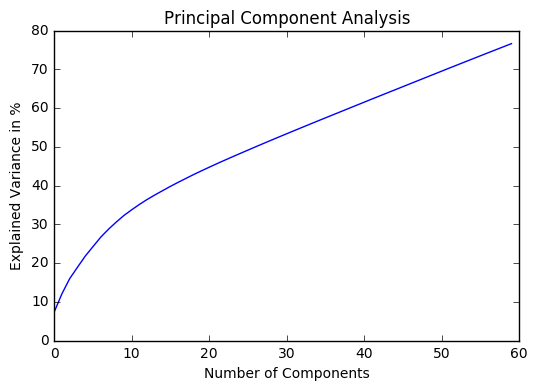

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline



#convert it to numpy arrays

y = loanData['loan_status']
X = loanData.drop(['loan_status'], axis = 1)

## Creating a holdout--Training data will be used to fit the models (80-20 ratio is taken)
# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

input= X_train.values
#Scaling the values
input = scale(input)

pca = PCA(n_components=60)

pca.fit(input)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)
plt.plot(var1)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance in %')
plt.title('Principal Component Analysis')
plt.legend(loc="lower right")
plt

#Looking at above plot I'm taking 30 variables
pca = PCA(n_components=50)
pca.fit(X)
X1=pca.fit_transform(X)

print(X1)

In [138]:
loanData.shape

(29150, 131)

In [139]:
loanData.loan_status

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
29120    1
29121    1
29122    1
29123    1
29124    1
29125    1
29126    1
29127    1
29128    1
29129    1
29130    1
29131    1
29132    1
29133    1
29134    1
29135    1
29136    1
29137    1
29138    1
29139    1
29140    1
29141    1
29142    1
29143    1
29144    1
29145    1
29146    1
29147    1
29148    1
29149    1
Name: loan_status, dtype: int64

In [116]:
n=pd.read_csv("LCData_Clean.csv",low_memory=False)

In [117]:
l = pd.read_csv("loanData_clean.csv", low_memory = False)

In [118]:
l

,Unnamed: 0,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,time_since_earliest_cr_line
0,0,11981122.0,20800.0,20800.0,20800.000000,36_months,13.53,706.16,B,B5,10+ years,RENT,81500.00,Verified,Dec-2013,0,n,NY,16.73,0.0,685.0,689.0,2.0,64.0,NaN,29.0,0.0,23473.0,54.5,41.0,f,0.0,71.0,0.0,0.0,23473.0,43100.0,9.0,869.0,6811.0,54.6,0.0,0.0,115.0,186.0,0.0,0.0,0.0,0.0,70.0,0.0,70.0,1.0,8.0,24.0,11.0,17.0,1.0,29.0,40.0,24.0,29.0,0.0,3.0,90.2,50.0,0.0,0.0,43100.0,23473.0,15000.0,0.0,579
1,2,11981072.0,12000.0,12000.0,12000.000000,36_months,10.99,392.81,B,B2,4 years,RENT,60000.00,Not Verified,Dec-2013,0,n,NC,4.62,0.0,720.0,724.0,1.0,NaN,NaN,15.0,0.0,7137.0,24.0,18.0,f,0.0,NaN,0.0,0.0,7137.0,29700.0,8.0,476.0,15216.0,15.9,0.0,0.0,NaN,48.0,1.0,1.0,0.0,1.0,NaN,3.0,NaN,0.0,4.0,7.0,8.0,10.0,0.0,15.0,18.0,7.0,15.0,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0,-3622
2,3,11991209.0,12000.0,12000.0,12000.000000,36_months,13.53,407.40,B,B5,10+ years,RENT,40000.00,Source Verified,Dec-2013,0,n,NM,16.94,0.0,660.0,664.0,0.0,53.0,33.0,7.0,2.0,5572.0,68.8,32.0,w,0.0,53.0,0.0,15386.0,13605.0,8100.0,4.0,2268.0,1428.0,79.6,0.0,0.0,124.0,182.0,1.0,1.0,0.0,11.0,53.0,17.0,53.0,6.0,2.0,2.0,3.0,14.0,8.0,6.0,24.0,2.0,7.0,0.0,2.0,81.2,33.3,0.0,0.0,18130.0,13605.0,7000.0,10030.0,457
3,4,11979581.0,24000.0,24000.0,24000.000000,36_months,13.53,814.80,B,B5,10+ years,MORTGAGE,100000.00,Verified,Dec-2013,0,n,MI,22.18,0.0,660.0,664.0,0.0,NaN,NaN,14.0,0.0,21617.0,76.7,39.0,w,0.0,NaN,0.0,539.0,199834.0,28200.0,7.0,15372.0,4822.0,77.6,0.0,0.0,179.0,299.0,18.0,7.0,3.0,18.0,NaN,7.0,NaN,0.0,3.0,5.0,5.0,10.0,17.0,8.0,19.0,5.0,14.0,0.0,2.0,100.0,75.0,0.0,0.0,229072.0,61397.0,21500.0,58847.0,4017
4,6,12001118.0,28000.0,28000.0,28000.000000,36_months,7.62,872.52,A,A3,5 years,MORTGAGE,325000.00,Source Verified,Dec-2013,0,n,CA,18.55,0.0,745.0,749.0,1.0,NaN,NaN,15.0,0.0,29581.0,54.6,31.0,w,0.0,NaN,0.0,0.0,799592.0,54200.0,6.0,53306.0,13901.0,67.1,0.0,0.0,125.0,229.0,5.0,2.0,5.0,5.0,NaN,3.0,NaN,0.0,4.0,5.0,6.0,8.0,11.0,9.0,15.0,5.0,15.0,0.0,5.0,100.0,16.7,0.0,0.0,850886.0,199739.0,42200.0,196686.0,1887
5,9,12031088.0,3000.0,3000.0,3000.000000,36_months,12.85,100.87,B,B4,10+ years,RENT,25000.00,Verified,Dec-2013,0,n,FL,24.68,0.0,660.0,664.0,0.0,58.0,53.0,5.0,2.0,2875.0,54.2,26.0,f,0.0,69.0,0.0,154.0,19530.0,5300.0,3.0,3906.0,2050.0,52.3,0.0,0.0,164.0,271.0,7.0,7.0,6.0,14.0,69.0,8.0,69.0,1.0,2.0,3.0,3.0,6.0,11.0,4.0,9.0,3.0,5.0,0.0,1.0,91.3,66.7,2.0,0.0,32082.0,19530.0,4300.0,26782.0,3167
6,10,12000897.0,27050.0,27050.0,27050.000000,36_months,10.99,885.46,B,B2,10+ years,OWN,55000.00,Verified,Dec-2013,0,n,MI,22.87,0.0,730.0,734.0,0.0,NaN,NaN,14.0,0.0,36638.0,61.2,27.0,w,0.0,NaN,0.0,0.0,114834.0,59900.0,3.0,9570.0,16473.0,53.9,0.0,0.0,117.0,326.0,16.0,6.0,4.0,16.0,NaN,8.0,NaN,0.0,2.0,4.0,4.0,8.0,8.0,10.0,15.0,4.0,14.0,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0,4840
7,12,12001033.0,4800.0,4800.0,4800.000000,36_months,10.99,157.13,B,B2,2 years,MORTGAGE,39600.